# SDSS: Active Learning

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from pandas import DataFrame, Index
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from scipy.spatial.distance import cosine
from IPython.core.display import HTML

%matplotlib inline
%run scripts/performance_measures.py
%run scripts/data_processing.py
%run scripts/visualisations.py

# plot formatting
sns.set_palette("husl", 7)

# stylesheet for notebook
HTML(open("styles/stylesheet.css", "r").read())

In [4]:
# read in the data
sdss = pd.io.parsers.read_csv("data/sdss_dr7_photometry.csv.gz", compression="gzip", index_col=["ra", "dec"])

# save the names of the 11 feature vectors and the target column
feature_names = ["psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z",
                 "petroMag_u", "petroMag_g", "petroMag_r", "petroMag_i", "petroMag_z", "petroRad_r"]
target_name = "class"

X_train, X_test, y_train, y_test = train_test_split(np.array(sdss[feature_names]), np.array(sdss['class']), train_size=100000, test_size=30000)

# shuffle the data
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

## Query by Committee

In [7]:
accuracies = []
predictions = [[] for i in range(10)]
forests = [None] * 11

# initially, pick 100 random points to query
X_train_cur, y_train_cur = X_train[:100], y_train[:100]
X_train_pool, y_train_pool = X_train[100:], y_train[100:]

# find the accuracy rate, given the current training example
forests[-1] = RandomForestClassifier(n_jobs=-1, class_weight='auto', random_state=5)
forests[-1].fit(X_train_cur, y_train_cur)
y_pred_test = forests[-1].predict(X_test)
confusion_test = metrics.confusion_matrix(y_test, y_pred_test)
accuracies.append(balanced_accuracy_expected(confusion_test))

# query by committee to pick the next point to sample
kfold = KFold(len(y_train_cur), n_folds=10, shuffle=True)
for i, (train_index, test_index) in enumerate(kfold):
    forests[i] = RandomForestClassifier(n_jobs=-1, class_weight='auto', random_state=5)
    forests[i].fit(X_train_cur[train_index], y_train_cur[train_index])
    predictions[i] = forests[i].predict(X_train_pool)
    


## Stochastic Gradient Descent

In [ ]:
# normalise features to have mean 0 and variance 1
scaler = StandardScaler()
scaler.fit(X_train)  # fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# approximates feature map of an RBF kernel by Monte Carlo approximation of its Fourier transform.
rbf_feature = RBFSampler(n_components=200, gamma=0.3, random_state=1)
X_train_rbf = rbf_feature.fit_transform(X_train)
X_test_rbf = rbf_feature.transform(X_test)

Random selection of data points at each iteration.

In [38]:
benchmark_sgd = SGDClassifier(loss="hinge", alpha=0.000001, penalty="l1", n_iter=10, n_jobs=-1,
                              class_weight='auto', fit_intercept=True, random_state=1)
benchmark_sgd.fit(X_train_rbf[:100], y_train[:100])
benchmark_y_pred = benchmark_sgd.predict(X_test_rbf)
benchmark_confusion = metrics.confusion_matrix(y_test, benchmark_y_pred)
benchmark_learning_curve = []
sample_sizes = np.concatenate((np.arange(100, 1000, 100), np.arange(1000, 10000, 1000), np.arange(10000, 100000, 10000),
                               np.arange(100000, 1000000, 100000), np.arange(1000000, len(X_train), 500000), [len(X_train)]))
benchmark_learning_curve.append(balanced_accuracy_expected(benchmark_confusion))
classes = np.unique(y_train)

for i, j in zip(sample_sizes[:-1], sample_sizes[1:]):
    for _ in range(10):
        X_train_partial, y_train_partial = shuffle(X_train_rbf[i:j], y_train[i:j])
        benchmark_sgd.partial_fit(X_train_partial, y_train_partial, classes=classes)
    benchmark_y_pred = benchmark_sgd.predict(X_test_rbf)
    benchmark_confusion = metrics.confusion_matrix(y_test, benchmark_y_pred)
    benchmark_learning_curve.append(balanced_accuracy_expected(benchmark_confusion))
    
# save output for later re-use
with open('results/sdss_active_learning/sgd_benchmark.pickle', 'wb') as f:
    pickle.dump((benchmark_sgd, sample_sizes, benchmark_learning_curve), f, pickle.HIGHEST_PROTOCOL)

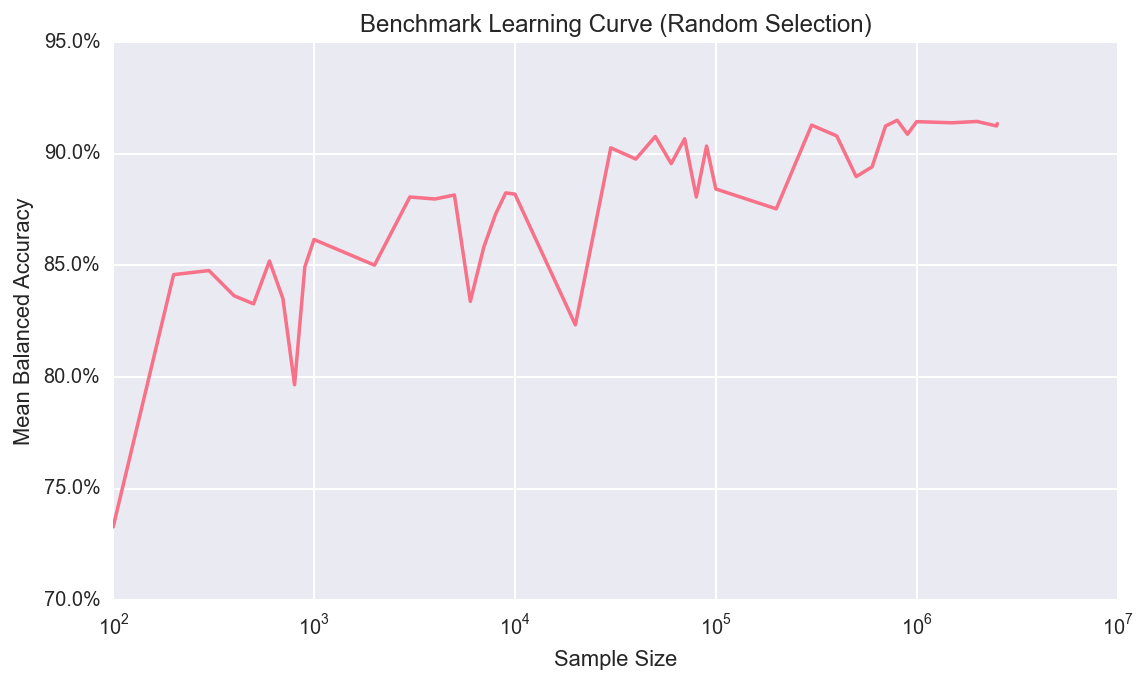

In [37]:
plot_learning_curve(sample_sizes, benchmark_learning_curve, "Benchmark Learning Curve (Random Selection)")

## SVM with Random Sampling

In [ ]:
svm_random = SVC(kernel='rbf', random_state=7, cache_size=2000, class_weight='auto')
svm_random.fit(X_train[:100], y_train[:100])
svm_y_pred = svm_random.predict(X_test)
svm_confusion = metrics.confusion_matrix(y_test, svm_y_pred)
svm_learning_curve = []
sample_sizes = np.concatenate((np.arange(200, 1000, 100), np.arange(1000, 20000, 1000)))
svm_learning_curve.append(balanced_accuracy_expected(svm_confusion))
previous_h = svm_random.predict(X_train)
rewards = []

for i in sample_sizes:
    svm_random.fit(X_train[:i], y_train[:i])
    svm_y_pred = svm_random.predict(X_test)
    svm_confusion = metrics.confusion_matrix(y_test, svm_y_pred)
    svm_learning_curve.append(balanced_accuracy_expected(svm_confusion))
    
    current_h = svm_random.predict(X_train)
    reward = 0
    for i, j in zip(current_h, previous_h):
        reward += 1 if i != j else 0
    reward = reward / len(current_h)
    previous_h = current_h
    rewards.append(reward)
    
# save output for later re-use
with open('results/sdss_active_learning/sgd_svm_random.pickle', 'wb') as f:
    pickle.dump((sample_sizes, svm_learning_curve, rewards), f, pickle.HIGHEST_PROTOCOL)

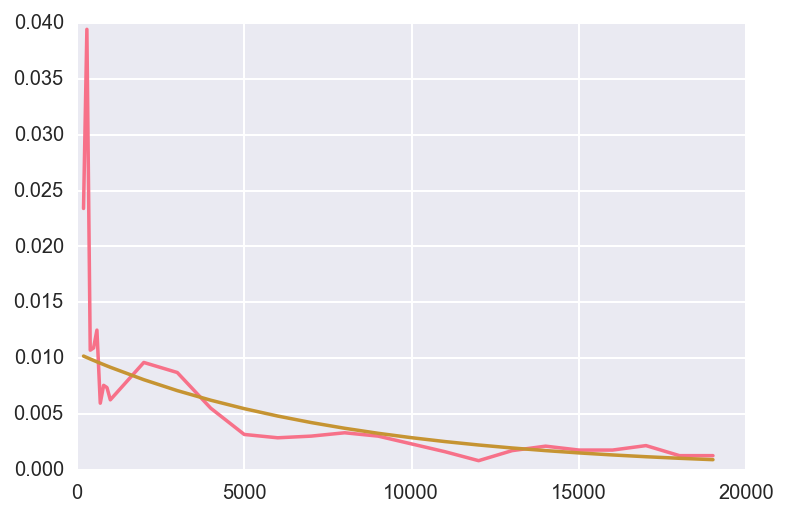

In [66]:
log_rewards = np.log(rewards)
beta, intercept = np.polyfit(sample_sizes, log_rewards, 1)
alpha = np.exp(intercept)

plt.plot(sample_sizes, rewards)
plt.plot(sample_sizes, alpha * np.exp(beta * sample_sizes))

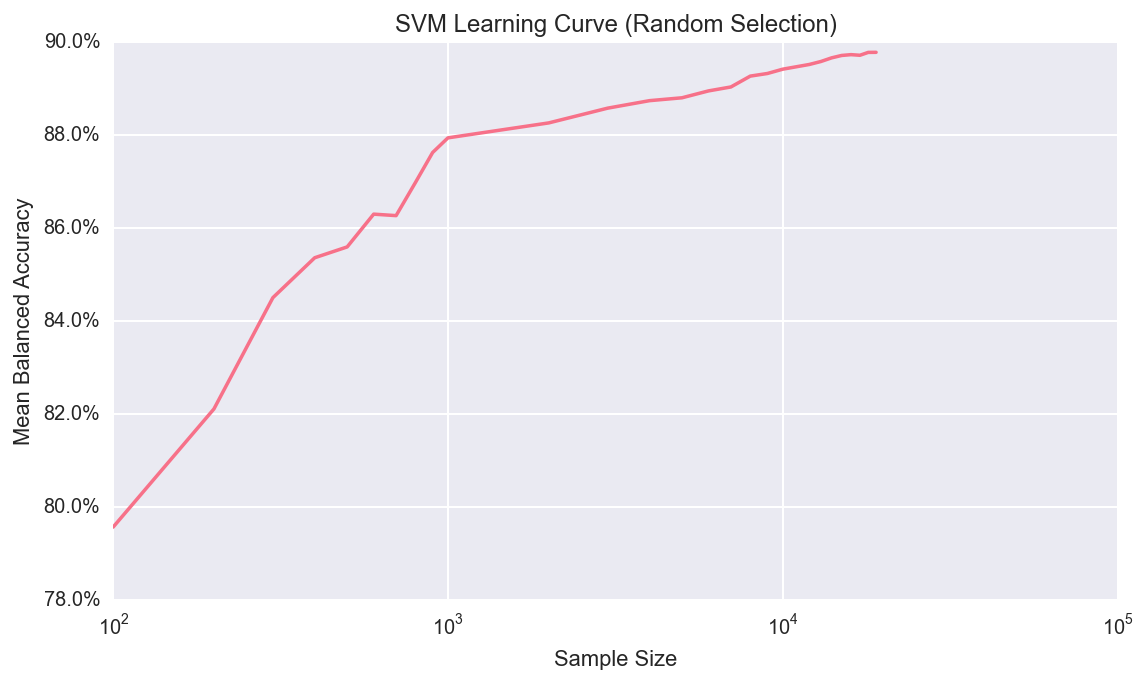

In [51]:
plot_learning_curve(sample_sizes, svm_learning_curve, "SVM Learning Curve (Random Selection)")

## Contextual Bandits

We implement a contextual bandit algorithm for active learning, suggested by <a href="https://hal.archives-ouvertes.fr/hal-01069802" target="_blank">Bouneffouf et al (2014)</a>.

In [183]:
n_clusters = 100
kmeans = MiniBatchKMeans(n_clusters=n_clusters, init_size=100*n_clusters, random_state=2)
X_train_transformed = kmeans.fit_transform(X_train)

Each cluster has a context vector containing 4 pieces of information:

* The mean distance between individual points in the cluster.
* The variance of the distance between individual points in the cluster.
* The number of points in the cluster.
* The proportion of points that have been labelled in the cluster.

In [184]:
unlabelled_points = set(range(0, len(X_train)))
empty_clusters = set()
cluster_sizes = [len(np.flatnonzero(kmeans.labels_ == i)) for i in range(n_clusters)]
cluster_points = [list(np.flatnonzero(kmeans.labels_ == i)) for i in range(n_clusters)]
no_labelled = [0 for i in range(n_clusters)]
prop_labelled = [0 for i in range(n_clusters)]

d_means = []
d_var = []
for i in range(n_clusters):
    distance, distance_squared, count = 0, 0, 0
    for j, p1 in enumerate(cluster_points[i]):
        for p2 in cluster_points[i][j+1:]:
            d = np.fabs(X_train_transformed[p1][i] - X_train_transformed[p2][i])
            distance += d  
            distance_squared += d**2
            count += 1
    
    if cluster_sizes[i] > 1:
        d_means.append(distance / count)
        d_var.append((distance_squared / count) - (distance / count)**2)
    else:
        d_means.append(0)
        d_var.append(0)

context = np.array([list(x)for x in zip(d_means, d_var, cluster_sizes, prop_labelled)])

We'll use Thompson Sampling with linear payoff and with Gaussian prior and likelihood. The algorithm is described in <a href="http://arxiv.org/abs/1209.3352" target="_blank">Argawal et al (2013)</a>.

In [185]:
context_size = 4
B = np.eye(context_size)
mu = np.array([0] * context_size)
f = np.array([0] * context_size)
v_squared = 0.25

Initially, we choose 100 random points to sample.

In [186]:
active_sgd = SVC(kernel='rbf', random_state=7, cache_size=2000, class_weight='auto')
#active_sgd = SGDClassifier(loss="hinge", alpha=0.000001, penalty="l1", n_iter=10, n_jobs=-1,
#                           class_weight='auto', fit_intercept=True, random_state=1)
X_train_cur, y_train_cur = X_train[:100], y_train[:100]

active_sgd.fit(X_train_cur, y_train_cur)

# update context
for i in np.arange(0, 100):
    this_cluster = kmeans.labels_[i]
    cluster_points[this_cluster].remove(i)
    unlabelled_points.remove(i)
    if not cluster_points[this_cluster]:
        empty_clusters.add(this_cluster)
    no_labelled[this_cluster] += 1
    context[this_cluster][3] = no_labelled[this_cluster] / cluster_sizes[this_cluster]

# initial prediction
active_y_pred = active_sgd.predict(X_test)
active_confusion = metrics.confusion_matrix(y_test, active_y_pred)
active_learning_curve = []
active_learning_curve.append(balanced_accuracy_expected(active_confusion))
classes = np.unique(y_train)

# compute the current hypothesis
previous_h = active_sgd.predict(X_train)

In [ ]:
active_steps = [100]
no_choices = 1
rewards = []

for i in range(2000 // no_choices):
    mu_sample = np.random.multivariate_normal(mu, v_squared * np.linalg.inv(B))
    reward_sample = [np.dot(c, mu_sample) for c in context]
    
    chosen_arm = np.argmax(reward_sample)
    while chosen_arm in empty_clusters:
        reward_sample[chosen_arm] = float('-inf')
        chosen_arm = np.argmax(reward_sample)
    
    # select a random point in the cluster
    query = np.random.choice(cluster_points[chosen_arm], min(len(cluster_points[chosen_arm]), no_choices), replace=False)
    
    # update context
    for q in query:
        cluster_points[chosen_arm].remove(q)
        unlabelled_points.remove(q)
    if not cluster_points[chosen_arm]:
        empty_clusters.add(chosen_arm)
    no_labelled[chosen_arm] += len(query)
    context[chosen_arm][3] = no_labelled[chosen_arm] / cluster_sizes[chosen_arm]
    active_steps.append(active_steps[-1] + len(query))
    
    # run stochastic gradient descent
    #active_sgd.partial_fit(X_train_rbf[query], y_train[query], classes=classes)
    X_train_cur = np.vstack((X_train_cur, X_train[query]))
    y_train_cur = np.concatenate((y_train_cur, y_train[query]))
    
    active_sgd = SVC(kernel='rbf', random_state=7, cache_size=2000, class_weight='auto')
    active_sgd.fit(X_train_cur, y_train_cur)
    
    active_y_pred = active_sgd.predict(X_test)
    active_confusion = metrics.confusion_matrix(y_test, active_y_pred)
    active_learning_curve.append(balanced_accuracy_expected(active_confusion))
    
    # compute the reward from choosing such arm
    current_h = active_sgd.predict(X_train)
    reward = 0
    for i, j in zip(current_h, previous_h):
        reward += 1 if i != j else 0
    reward = reward / len(current_h)
    reward = reward / (alpha * np.exp(beta * len(y_train_cur)))
    previous_h = current_h
    rewards.append(reward)
    
    # compute posterior distribution
    B = B + np.outer(context[chosen_arm], context[chosen_arm])
    f = f + reward * context[chosen_arm]
    mu = np.dot(np.linalg.inv(B), f)
    

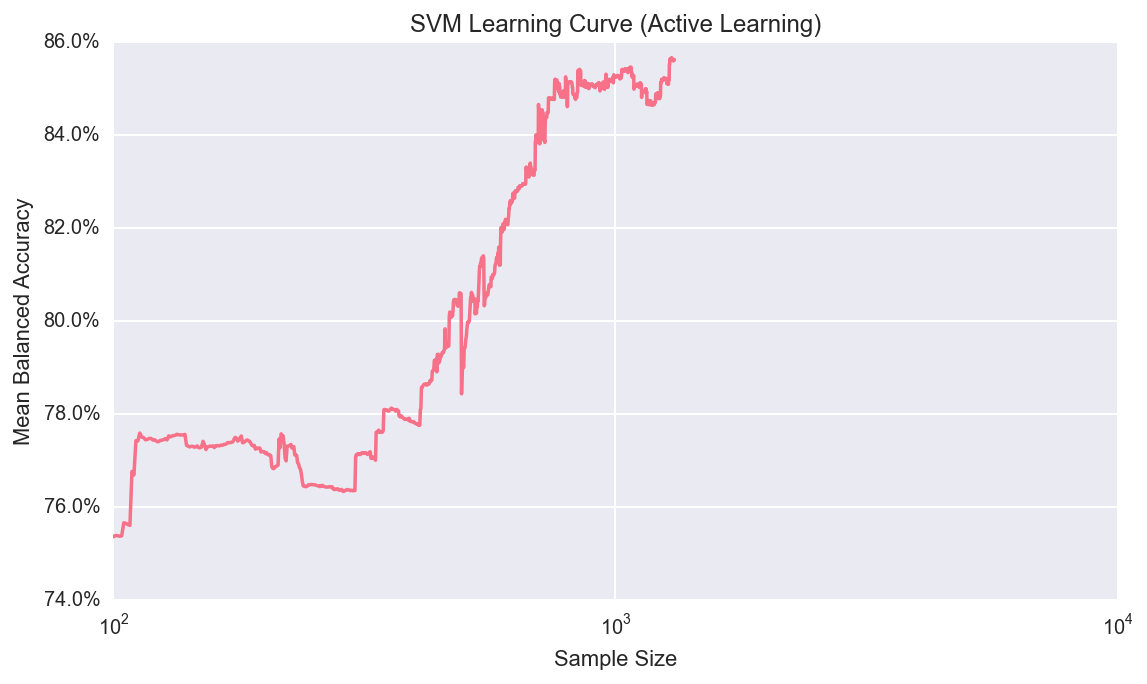

In [188]:
plot_learning_curve(active_steps, active_learning_curve, "SVM Learning Curve (Active Learning)")